# Inverse Modeling of Quadrupole Gradient Errors by Matching the Orbit Response Matrix

This example introduces errors to quadrupole gradient strengths and the goal of the differentiable simulation is to infer these errors by matching the Orbit Response Matrix (ORM) was well as the tunes of the resulting lattice. MADX simulations are used to provide the reference data corresponding to the lattice with errors.

Running the example script will perform the following steps:

1. Define the lattice
2. Assign a random field error to the third quadrupole of each triplet: `file = "errors"`
3. Compute Twiss of the sequence with errors: `file = "twiss"`

Here we only assign one error per triplet since the magnets that form a triplet are located very close together. For that reason the compensation of neighboring field errors is quite effective which considerably slows down the convergence of the optimization process. Assigning one error per triplet is equivalent to having only one free variable per triplet (e.g. if all magnets shared the same power supply).

In [1]:
import os.path
from dipas.madx import run_file

result = run_file('example.madx', results=['twiss+meta', 'errors'],
                  madx=os.path.expanduser('~/bin/madx'))

twiss_ref = result['twiss']
errors = result['errors']

twiss_ref[0].set_index('NAME', inplace=True)  # [0] is the twiss data, [1] is the meta data ("@"-prefixed in the TFS file)
errors.set_index('NAME', inplace=True)

Let's check the K1L values and associated errors for all magnets. As mentioned above, only the third magnet in each triplet (`*QS3`) has been assigned an error:

In [2]:
import pandas as pd

k1_values = pd.DataFrame({
    'K1L':  twiss_ref[0]['K1L'].loc[errors.index],
    'Errors': errors['K1L'],
})
print(k1_values)

              K1L    Errors
NAME                       
YR02QS1  0.508655  0.000000
YR02QS2 -0.651115  0.000000
YR02QS3  0.508655  0.011836
YR04QS1  0.508655  0.000000
YR04QS2 -0.651115  0.000000
YR04QS3  0.508655  0.011628
YR06QS1  0.508655  0.000000
YR06QS2 -0.651115  0.000000
YR06QS3  0.508655 -0.008112
YR08QS1  0.508655  0.000000
YR08QS2 -0.651115  0.000000
YR08QS3  0.508655 -0.003652
YR10QS1  0.508655  0.000000
YR10QS2 -0.651115  0.000000
YR10QS3  0.508655  0.011761
YR12QS1  0.508655  0.000000
YR12QS2 -0.651115  0.000000
YR12QS3  0.508655  0.006400


Now we load the lattice from the MADX file and declare the relevant quadrupole's k1-errors as optimization parameters in order to infer the actual values:

In [3]:
from dipas.build import from_file
from dipas.elements import Quadrupole
import torch

lattice = from_file('example.madx', errors=False)  # use `errors=False` to load the nominal optics
for quad in lattice['yr*qs3']:
    quad.dk1 = torch.nn.Parameter(quad.dk1)
    quad.update_transfer_map()  # make changes to `dk1` effective
print('# parameters: ', len(list(lattice.parameters())))

# parameters:  6


With the utility function `dipas.madx.run_orm` we can have MADX compute the Orbit Response Matrix for the given script file. Here we only consider the vertical component of the ORM. This will serve as the reference data against which the model will be matched.

In [4]:
from dipas.elements import VKicker, VMonitor
from dipas.madx import run_orm

kicker_labels = [x.label for x in lattice[VKicker]]
monitor_labels = [x.label for x in lattice[VMonitor]]

orm_ref = run_orm('example.madx',
                  kickers=kicker_labels,
                  monitors=monitor_labels,
                  madx=os.path.expanduser('~/bin/madx'))

orm_ref = orm_ref.loc[:, 'Y']  # only consider the vertical component
print(orm_ref)  # rows are kickers, columns are monitors

         yr02dx2   yr03dx2   yr03dx3   yr06dx2   yr07dx2   yr08dx2   yr10dx2  \
yr02kv  1.115240  1.983728  1.972641 -2.891744  1.823880  3.705735 -3.214685   
yr04kv  0.809330  1.921067  1.954103  1.436141 -2.135845 -2.999211  3.510664   
yr07kv -0.233959 -1.277466 -1.348631  2.203000  1.410669  2.204617 -2.361074   
yr08kv  3.705474  0.733856  0.197256  1.247780  1.900128  1.201006  1.044550   
yr10kv -3.056570  0.464584  0.998505 -3.012275 -0.807507  1.309568  1.132972   
yr12kv  1.180532 -1.503768 -1.822981  3.617948 -0.628670 -3.078852  1.449289   

         yr11dx2   yr12dx2  
yr02kv -0.971380  1.443970  
yr04kv -0.022372 -2.643008  
yr07kv -0.178819  1.586732  
yr08kv -2.170915 -2.916487  
yr10kv  2.065269  1.186817  
yr12kv  1.893791  1.050390  


Using `dipas.compute.orm` we can compute the ORM for the given lattice, in dependency on the quadrupole gradient errors which we have previously declared as parameters:

In [5]:
import dipas.compute as compute

orm_x, orm_y = compute.orm(lattice, kickers=VKicker, monitors=VMonitor)
orm_y = pd.DataFrame(data=orm_y.detach().numpy(), index=orm_ref.index, columns=orm_ref.columns)
print(orm_y)

         yr02dx2   yr03dx2   yr03dx3   yr06dx2   yr07dx2   yr08dx2   yr10dx2  \
yr02kv  1.051808  1.992815  1.989703 -2.950579  1.775919  3.689564 -3.108786   
yr04kv  0.859713  1.864128  1.881479  1.546831 -2.106485 -3.043805  3.452004   
yr07kv -0.295694 -1.264483 -1.323158  2.149441  1.414799  2.254200 -2.355583   
yr08kv  3.689564  0.712763  0.171017  1.415990  1.853362  1.051808  1.156167   
yr10kv -2.950579  0.484488  1.006893 -3.108786 -0.747051  1.415990  1.051808   
yr12kv  1.156167 -1.508437 -1.824636  3.689564 -0.626480 -3.108786  1.415990   

         yr11dx2   yr12dx2  
yr02kv -0.946485  1.415990  
yr04kv -0.022300 -2.625416  
yr07kv -0.165343  1.614370  
yr08kv -2.118423 -2.950579  
yr10kv  1.986812  1.156167  
yr12kv  1.886741  1.051808  


Since the above `lattice` has no gradient errors so far, the result is quite different. The goal is to align the two ORMs so that their values match.

Similarly we can compute the tunes via `dipas.compute.twiss`:

In [6]:
from dipas.elements import Kicker

twiss = compute.twiss(lattice.makethin({Kicker: 2}, style={Kicker: 'edge'}))  # MADX uses 'edge' style

print(f'Tunes:     Q1 = {twiss["Q1"]:.3f}, Q2 = {twiss["Q2"]:.3f}')
print(f'Reference: Q1 = {twiss_ref[1]["Q1"]:.3f}, Q2 = {twiss_ref[1]["Q2"]:.3f}')

Tunes:     Q1 = 2.420, Q2 = 2.420
Reference: Q1 = 2.439, Q2 = 2.411


In the following we setup and run the optimization process. For that purpose we need to define an `optimizer` as well as compute the necessary quantities during each step of the optimization.

In [7]:
import itertools as it
from dipas.elements import tensor

optimizer = torch.optim.Adam(lattice.parameters(), lr=1.8e-3, betas=(0.51, 0.96))

quadrupoles = lattice['yr*qs3']

Q1 = twiss_ref[1]["Q1"]
Q2 = twiss_ref[1]["Q2"]
orm_ref_y = torch.from_numpy(orm_ref.to_numpy())

cost_history = []
dk1_history = []

for step in it.count(1):
    optimizer.zero_grad()
        
    orm_y = compute.orm(lattice, kickers=VKicker, monitors=VMonitor)[1]
    cost1 = torch.nn.functional.mse_loss(orm_y, orm_ref_y)

    try:
        twiss = compute.twiss(lattice.makethin({Kicker: 2}, style={Kicker: 'edge'}))
    except compute.UnstableLatticeError:
        cost2 = tensor(0.)
    else:
        cost2 = (twiss['Q1'] - Q1)**2 + (twiss['Q2'] - Q2)**2

    cost = cost1 + cost2
    cost.backward(retain_graph=True)
        
    cost_history.append(cost.item())
    dk1_history.append([quad.dk1.item() for quad in quadrupoles])
    print(f'[Step {step:03d}] cost = {cost_history[-1]:.3e}')
    
    optimizer.step()
    
    if cost_history[-1] < 1e-12:  # if converged
        break
        
    for quad in quadrupoles:
        quad.update_transfer_map()  # make changes from `optimizer.step()` effective

[Step 001] cost = 4.005e-03
[Step 002] cost = 3.628e-03
[Step 003] cost = 3.276e-03
[Step 004] cost = 2.946e-03
[Step 005] cost = 2.636e-03
[Step 006] cost = 2.348e-03
[Step 007] cost = 2.082e-03
[Step 008] cost = 1.841e-03
[Step 009] cost = 1.622e-03
[Step 010] cost = 1.425e-03
[Step 011] cost = 1.247e-03
[Step 012] cost = 1.087e-03
[Step 013] cost = 9.440e-04
[Step 014] cost = 8.166e-04
[Step 015] cost = 7.039e-04
[Step 016] cost = 6.046e-04
[Step 017] cost = 5.174e-04
[Step 018] cost = 4.410e-04
[Step 019] cost = 3.746e-04
[Step 020] cost = 3.170e-04
[Step 021] cost = 2.674e-04
[Step 022] cost = 2.248e-04
[Step 023] cost = 1.883e-04
[Step 024] cost = 1.573e-04
[Step 025] cost = 1.309e-04
[Step 026] cost = 1.087e-04
[Step 027] cost = 8.997e-05
[Step 028] cost = 7.428e-05
[Step 029] cost = 6.117e-05
[Step 030] cost = 5.025e-05
[Step 031] cost = 4.118e-05
[Step 032] cost = 3.367e-05
[Step 033] cost = 2.748e-05
[Step 034] cost = 2.238e-05
[Step 035] cost = 1.819e-05
[Step 036] cost = 1.

We can check the k1-error values during the optimization in order to assess the convergence:

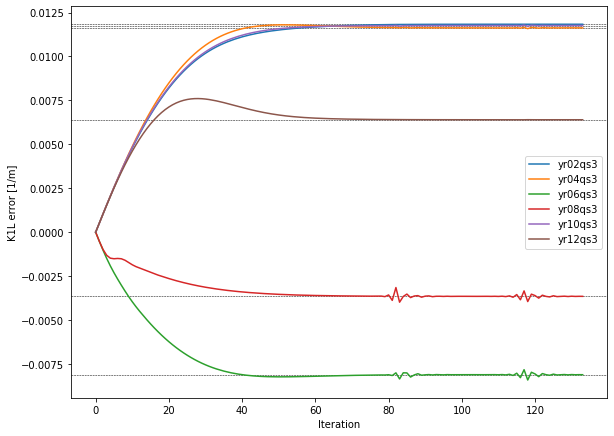

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

dk1_history = np.array(dk1_history)

fig, ax = plt.subplots(figsize=(9.6, 7.2))
ax.set(xlabel='Iteration', ylabel='K1L error [1/m]')
for i, quad in enumerate(quadrupoles):
    ax.plot(dk1_history[:, i]*quad.l.item(), label=quad.label)
    ax.axhline(errors.loc[quad.label.upper(), 'K1L'], lw=0.5, ls='--', color='black', zorder=-100)
ax.legend()

The small wiggles towards the end of the `yr06qs3` and `yr08qs3` lines come from the particular structure of the parameter space close to the target values. The considered quadrupoles in the lattice have a certain capability to compensate each other's over- or underestimation of the true parameter values. This creates a region of strong compensation were the considered cost function (ORM + tunes) barely changes, resulting in a very slow, asymptotic convergence, as can be seen for iteration 40 or later. Perpendicular to that region however the cost increases very rapidly, so small misalignments of the optimizer momentum with respect to that region can lead to a digression from the "optimal" route, causing transverse oscillations in parameter space which are eventually damped away. Being mostly perpendicular to the direction towards the target this ususally doesn't hinder convergence. Nevertheless the convergence properties largely depend on the used optimizer and its settings, so a systematic screening of the available options is recommended.

We can also check the cost function during the optimization which reflects the above observed wiggles as well. Nevertheless, imagining a continuation of the cost trend line beyond iteration 75 arrives at approximately the same number of iterations needed to reach $10^{-12}$ MSE level (i.e. the wiggles don't hinder the convergence process).

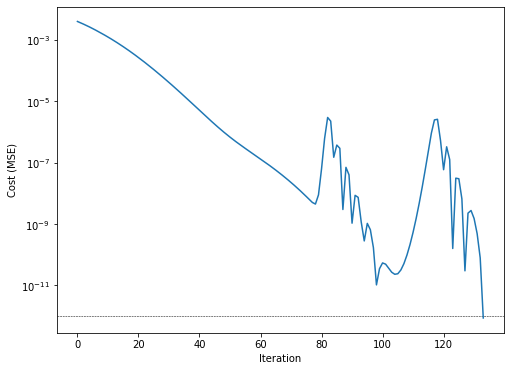

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set(xlabel='Iteration', ylabel='Cost (MSE)')
ax.set_yscale('log')
ax.plot(cost_history)
ax.axhline(1e-12, lw=0.5, ls='--', color='black', zorder=-100)

Finally we run a crosscheck with MADX, using the derived k1-error values, in order to confirm that the computed ORM does indeed match our computation:

In [10]:
from dipas.build import create_script

script = create_script(
    beam=dict(particle='proton', energy=1),
    sequence=lattice,
    errors=True)

with open('crosscheck_orm.madx', 'w') as fh:
    fh.write(script)

orm_cc = run_orm('crosscheck_orm.madx',
                 kickers=kicker_labels,
                 monitors=monitor_labels,
                 madx=os.path.expanduser('~/bin/madx'))
orm_cc = orm_cc.loc[:, 'Y']

print('Deviation between computed and crosscheck ORM:', end='\n\n')
print(orm_cc - orm_ref)

Deviation between computed and crosscheck ORM:

             yr02dx2       yr03dx2       yr03dx3       yr06dx2       yr07dx2  \
yr02kv -6.660000e-06 -2.938000e-06 -2.112000e-06  6.800000e-07 -1.357000e-06   
yr04kv  4.068900e-06  1.354000e-06  8.110000e-07 -4.800000e-08  1.835000e-06   
yr07kv -1.316000e-06  3.540000e-07  5.970000e-07 -1.382000e-06 -2.987000e-06   
yr08kv -9.660000e-07  7.280000e-07  9.459000e-07 -1.028000e-06 -3.304000e-06   
yr10kv -4.969000e-06 -3.296800e-06 -2.774300e-06  1.558000e-06  1.244100e-06   
yr12kv  7.332000e-06  3.797000e-06  2.936000e-06 -1.186000e-06  1.344000e-07   

             yr08dx2       yr10dx2       yr11dx2       yr12dx2  
yr02kv -9.540000e-07 -4.630000e-06  3.543900e-06  7.109000e-06  
yr04kv  1.531000e-06  1.902000e-06 -2.322250e-06 -3.865000e-06  
yr07kv -2.521000e-06  9.580000e-07  9.788000e-07  3.590000e-07  
yr08kv -3.103000e-06  1.396000e-06  7.440000e-07 -3.190000e-07  
yr10kv  1.284000e-06 -5.831000e-06  2.325000e-06  6.553000e-06  
y